<a href="https://colab.research.google.com/github/SurangaPrasad/deep_learning/blob/main/transfer_learning_v1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ***ResNet18 Model***

### Train validate and test using ***miniImageNet*** data set

In [1]:
## import python scrips from "https://github.com/SurangaPrasad/deep_learning.git"

import torch
import torchvision
from torch import nn
from torchvision import transforms

try:
    from modular import helper, dl_engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find modular scripts... downloading them from GitHub.")
    !git clone https://github.com/SurangaPrasad/deep_learning.git
    !mv deep_learning/modular/ .
    !rm -rf deep_learning
    from modular import helper, dl_engine

[INFO] Couldn't find modular scripts... downloading them from GitHub.
Cloning into 'deep_learning'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 75 (delta 33), reused 5 (delta 0), pack-reused 0
Receiving objects: 100% (75/75), 251.08 KiB | 1.34 MiB/s, done.
Resolving deltas: 100% (33/33), done.
The selected device is cuda


In [2]:
#!rm -rf modular

In [3]:
## download and create the data loaders

import os
import gdown
from pathlib import Path

# set the device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"The selected device is {device}")

data_path = Path("data/")
image_path = data_path / "mini_image_net"

url = 'https://drive.usercontent.google.com/download?id=107FTosYIeBn5QbynR46YG91nHcJ70whs&export=download&authuser=0&confirm=t&uuid=60b63e1a-f494-4f24-bdb1-b55131562a39&at=APZUnTVF0wI3FBlvrHXL3r-PlZjg:1704103333738'

helper.download_and_extract(data_path, image_path, url,"mini_image_net.tar",False)

## geting the weight of pretrained model
weights = torchvision.models.ResNet18_Weights.DEFAULT

# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()

#Splitting data in to train, test and validation
originalDataset = torchvision.datasets.ImageFolder(image_path/ "train", transform = auto_transforms)
random_gen = torch.Generator().manual_seed(42)

test_data, train_data, val_data = torch.utils.data.random_split(originalDataset, [0.8, 0.1, 0.1] , generator=random_gen)
class_names = originalDataset.classes

# Create training, testing and validation DataLoaders
train_dataloader, test_dataloader,valid_dataloader = helper.create_dataloaders(train_data,
                                                                               test_data,
                                                                               val_data,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32



The selected device is cuda
Did not find data/mini_image_net directory, creating one...
Unzipping tar file...


In [4]:
##train, validate and test model

##loading pretrained model
model_resnet_18 = torchvision.models.resnet18(weights, progress = True)

#Freezing parameters
for param in model_resnet_18.parameters():
    param.requires_grad = False

output_shape = len(originalDataset.classes)

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Recreate the fc layer and seed it to the target device
model_resnet_18.fc = torch.nn.Linear(in_features=512,
                                     out_features=output_shape, # same number of output units as our number of classes
                                     bias=True).to(device)

# Define loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet_18.parameters(), lr=0.001)



# Start the timer
from timeit import default_timer as timer
start_time = timer()
epoches = 10

train_val_results = dl_engine.train(model_resnet_18, train_dataloader, valid_dataloader, loss_function, optimizer, epoches)
acc_test,loss_test = dl_engine.eval(model_resnet_18, test_dataloader, loss_function)

print('accuracy on testing data: %f' % acc_test) #  a reference output is provided below:

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 101MB/s]


epoch: 0, lr: 0.001000, accuracy: 0.300781, loss: 2.197062, valid accuracy: 0.584375
accuracy on testing data: 0.733496
[INFO] Total training time: 323.497 seconds


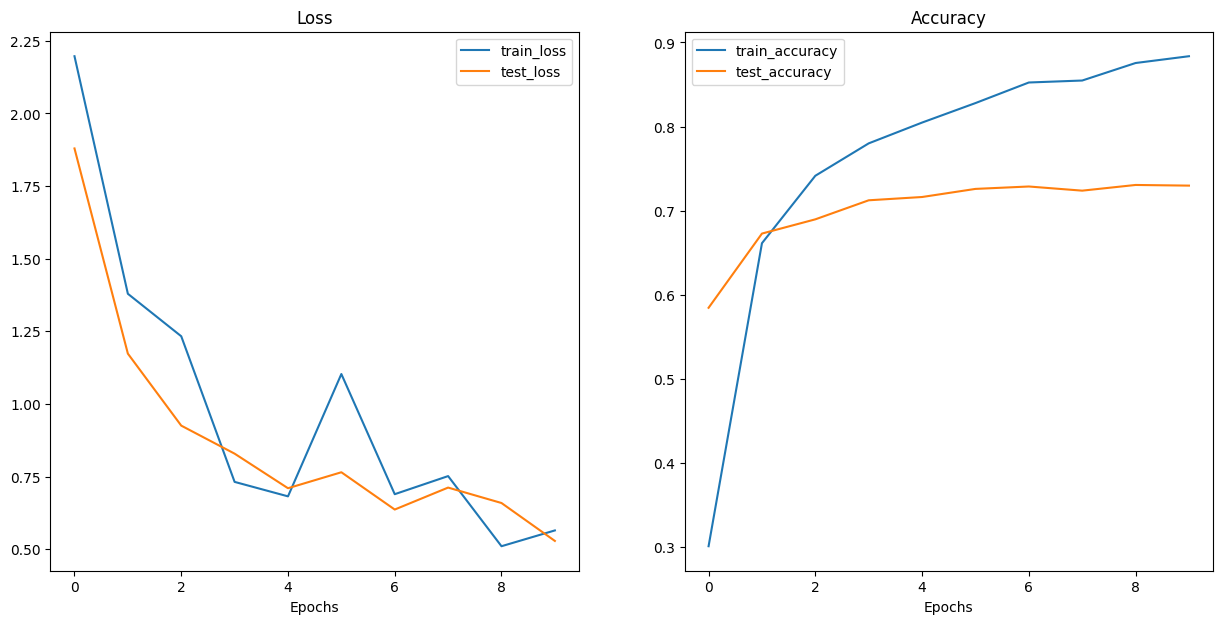

In [5]:
helper.plot_loss_curves(train_val_results)

### Finetuning using EuroSat data set

In [9]:
#download and extract EuroSat data set

from pathlib import Path
data_path = Path("data/")
image_path = data_path / "eurosat"
url = "https://madm.dfki.de/files/sentinel/EuroSAT.zip"

helper.download_and_extract(data_path,image_path, url, "eurosat.zip")

eurosat_dataset = torchvision.datasets.ImageFolder(image_path / "2750")
output_shape = len(eurosat_dataset.classes)

## Converting above training and testing data sets in to data loaders
import random
import numpy as np
import torchvision
import torch


# Start the timer
from timeit import default_timer as timer
start_time = timer()
epoches = 20

# Recreate the fc layer according to data set
model_resnet_18.fc = torch.nn.Linear(in_features=512,
                                     out_features=output_shape, # same number of output units as our number of classes
                                     bias=True).to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet_18.parameters(), lr=0.001)

for staring_number in range(0,20):
  train_loader_eurosat, test_loader_eurosat = helper.getEuroSatDataLoaders(staring_number, eurosat_dataset)
  train_val_results = dl_engine.train(model_resnet_18, train_loader_eurosat, test_loader_eurosat, loss_function, optimizer, epoches)

##creating a testing data loader and testing the model performance

staring_number = 30  # set the starting nnumber to 20 for collecting different test data set

train_loader_eurosat, test_loader_eurosat = helper.getEuroSatDataLoaders(staring_number, eurosat_dataset)
acc_test,loss_test = dl_engine.eval(model_resnet_18, test_loader_eurosat, loss_function)

print('accuracy on testing data: %f' % acc_test) #  a reference output is provided below:

end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")



data/eurosat directory exists.
epoch: 0, lr: 0.001000, accuracy: 0.280000, loss: 2.232349, valid accuracy: 0.240000
epoch: 10, lr: 0.001000, accuracy: 0.960000, loss: 0.779718, valid accuracy: 0.600000
epoch: 0, lr: 0.001000, accuracy: 0.520000, loss: 3.175915, valid accuracy: 0.533333
epoch: 10, lr: 0.001000, accuracy: 0.600000, loss: 0.898080, valid accuracy: 0.560000
epoch: 0, lr: 0.001000, accuracy: 0.760000, loss: 1.183801, valid accuracy: 0.480000
epoch: 10, lr: 0.001000, accuracy: 0.960000, loss: 0.325698, valid accuracy: 0.746667
epoch: 0, lr: 0.001000, accuracy: 0.360000, loss: 4.714230, valid accuracy: 0.226667
epoch: 10, lr: 0.001000, accuracy: 0.720000, loss: 0.921193, valid accuracy: 0.386667
epoch: 0, lr: 0.001000, accuracy: 0.480000, loss: 2.045245, valid accuracy: 0.240000
epoch: 10, lr: 0.001000, accuracy: 0.960000, loss: 0.233613, valid accuracy: 0.680000
epoch: 0, lr: 0.001000, accuracy: 0.200000, loss: 4.801134, valid accuracy: 0.146667
epoch: 10, lr: 0.001000, accu

## ***VGG11 Model***

###Train validate and test using miniImageNet data set

In [14]:
## geting the weight of pretrained model
weights_vgg11 = torchvision.models.VGG11_Weights.IMAGENET1K_V1

# Get the transforms used to create our pretrained weights
auto_transforms = weights_vgg11.transforms()

data_path = Path("data/")
image_path = data_path / "mini_image_net"

#Splitting data in to train, test and validation
originalDataset = torchvision.datasets.ImageFolder(image_path/ "train", transform = auto_transforms)
random_gen = torch.Generator().manual_seed(42)

test_data, train_data, val_data = torch.utils.data.random_split(originalDataset, [0.8, 0.1, 0.1] , generator=random_gen)
class_names = originalDataset.classes

# Create training, testing and validation DataLoaders
train_dataloader, test_dataloader,valid_dataloader = helper.create_dataloaders(train_data,
                                                                               test_data,
                                                                               val_data,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

In [15]:
##train, validate and test model

##loading pretrained model
model_vgg_11 = torchvision.models.vgg11(weights_vgg11, progress = True)

#Freezing parameters
for param in model_vgg_11.parameters():
    param.requires_grad = False

output_shape = len(originalDataset.classes)

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Recreate the fc layer and seed it to the target device
model_vgg_11.classifier[-1] = torch.nn.Linear(in_features=4096,  # Assuming the default in_features for VGG16
                                              out_features=output_shape,
                                              bias=True).to(device)

# Define loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_vgg_11.parameters(), lr=0.001)



# Start the timer
from timeit import default_timer as timer
start_time = timer()
epoches = 10

train_val_results = dl_engine.train(model_vgg_11, train_dataloader, valid_dataloader, loss_function, optimizer, epoches)
acc_test,loss_test = dl_engine.eval(model_vgg_11, test_dataloader, loss_function)

print('accuracy on testing data: %f' % acc_test) #  a reference output is provided below:

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")
helper.plot_loss_curves(train_val_results)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:07<00:00, 74.1MB/s]


epoch: 0, lr: 0.001000, accuracy: 0.531510, loss: 1.353464, valid accuracy: 0.711979
accuracy on testing data: 0.732715
[INFO] Total training time: 349.109 seconds


##Finetuning using EuroSat data set

In [17]:
image_path = data_path / "eurosat"
eurosat_dataset = torchvision.datasets.ImageFolder(image_path / "2750")
output_shape = len(eurosat_dataset.classes)

## Converting above training and testing data sets in to data loaders
import random
import numpy as np
import torchvision
import torch


# Start the timer
from timeit import default_timer as timer
start_time = timer()
epoches = 20

# Recreate the fc layer and seed it to the target device
model_vgg_11.classifier[-1] = torch.nn.Linear(in_features=4096,  # Assuming the default in_features for VGG16
                                              out_features=output_shape,
                                              bias=True).to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_vgg_11.parameters(), lr=0.001)

for staring_number in range(0,20):
  train_loader_eurosat, test_loader_eurosat = helper.getEuroSatDataLoaders(staring_number, eurosat_dataset)
  train_val_results = dl_engine.train(model_vgg_11, train_loader_eurosat, test_loader_eurosat, loss_function, optimizer, epoches)

##creating a testing data loader and testing the model performance

staring_number = 30  # set the starting nnumber to 20 for collecting different test data set

train_loader_eurosat, test_loader_eurosat = helper.getEuroSatDataLoaders(staring_number, eurosat_dataset)
acc_test,loss_test = dl_engine.eval(model_vgg_11, test_loader_eurosat, loss_function)

print('accuracy on testing data: %f' % acc_test) #  a reference output is provided below:

end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")


epoch: 0, lr: 0.001000, accuracy: 0.120000, loss: 2.298352, valid accuracy: 0.613333
epoch: 10, lr: 0.001000, accuracy: 0.960000, loss: 0.558363, valid accuracy: 0.706667
epoch: 0, lr: 0.001000, accuracy: 0.560000, loss: 3.328066, valid accuracy: 0.426667
epoch: 10, lr: 0.001000, accuracy: 0.600000, loss: 1.219560, valid accuracy: 0.400000
epoch: 0, lr: 0.001000, accuracy: 0.480000, loss: 3.934963, valid accuracy: 0.306667
epoch: 10, lr: 0.001000, accuracy: 0.760000, loss: 0.829043, valid accuracy: 0.693333
epoch: 0, lr: 0.001000, accuracy: 0.560000, loss: 2.837266, valid accuracy: 0.413333
epoch: 10, lr: 0.001000, accuracy: 0.960000, loss: 0.373361, valid accuracy: 0.613333
epoch: 0, lr: 0.001000, accuracy: 0.360000, loss: 2.228365, valid accuracy: 0.173333
epoch: 10, lr: 0.001000, accuracy: 0.920000, loss: 0.281930, valid accuracy: 0.626667
epoch: 0, lr: 0.001000, accuracy: 0.560000, loss: 1.655771, valid accuracy: 0.373333
epoch: 10, lr: 0.001000, accuracy: 0.840000, loss: 0.329160,

## ***VIT_B_16 Model***

###Train validate and test using miniImageNet data set

In [18]:
## geting the weight of pretrained model
weights_vit_b_16 = torchvision.models.ViT_B_16_Weights.IMAGENET1K_V1

# Get the transforms used to create our pretrained weights
auto_transforms = weights_vit_b_16.transforms()

data_path = Path("data/")
image_path = data_path / "mini_image_net"

#Splitting data in to train, test and validation
originalDataset = torchvision.datasets.ImageFolder(image_path/ "train", transform = auto_transforms)
random_gen = torch.Generator().manual_seed(42)

test_data, train_data, val_data = torch.utils.data.random_split(originalDataset, [0.8, 0.1, 0.1] , generator=random_gen)
class_names = originalDataset.classes

# Create training, testing and validation DataLoaders
train_dataloader, test_dataloader,valid_dataloader = helper.create_dataloaders(train_data,
                                                                               test_data,
                                                                               val_data,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

In [19]:
##train, validate and test model

##loading pretrained model
model_vit_b_16 = torchvision.models.vit_b_16(weights_vit_b_16, progress = True)

#Freezing parameters
for param in model_vit_b_16.parameters():
    param.requires_grad = False

output_shape = len(originalDataset.classes)

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)


model_vit_b_16.heads = torch.nn.Linear(in_features=768,
                                       out_features=output_shape, # same number of output units as our number of classes
                                       bias=True).to(device)

# Define loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_vit_b_16.parameters(), lr=0.001)



# Start the timer
from timeit import default_timer as timer
start_time = timer()
epoches = 10

train_val_results = dl_engine.train(model_vit_b_16, train_dataloader, valid_dataloader, loss_function, optimizer, epoches)
acc_test,loss_test = dl_engine.eval(model_vit_b_16, test_dataloader, loss_function)

print('accuracy on testing data: %f' % acc_test) #  a reference output is provided below:

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")
helper.plot_loss_curves(train_val_results)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:06<00:00, 56.9MB/s]


epoch: 0, lr: 0.001000, accuracy: 0.800000, loss: 0.266755, valid accuracy: 0.916406


KeyboardInterrupt: 

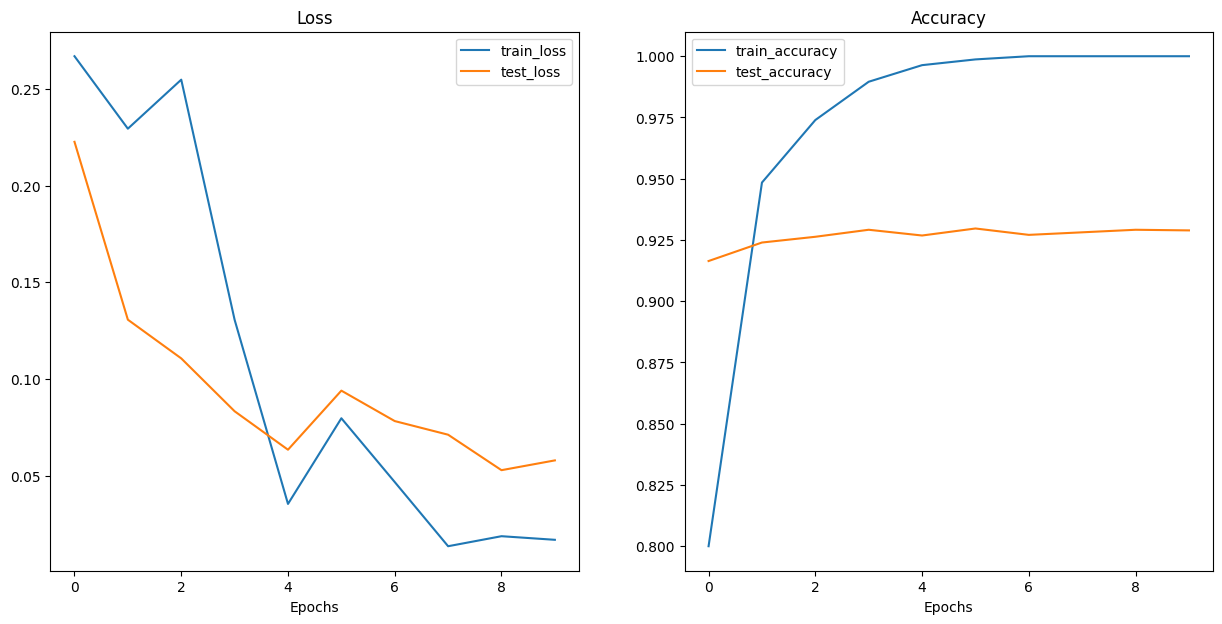

In [20]:
helper.plot_loss_curves(train_val_results)

###Finetuning using EuroSat data set

In [ ]:
image_path = data_path / "eurosat"
eurosat_dataset = torchvision.datasets.ImageFolder(image_path / "2750")
output_shape = len(eurosat_dataset.classes)

## Converting above training and testing data sets in to data loaders
import random
import numpy as np
import torchvision
import torch


# Start the timer
from timeit import default_timer as timer
start_time = timer()
epoches = 20

model_vit_b_16.heads = torch.nn.Linear(in_features=768,
                                       out_features=output_shape, # same number of output units as our number of classes
                                       bias=True).to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_vit_b_16.parameters(), lr=0.001)

for staring_number in range(0,20):
  train_loader_eurosat, test_loader_eurosat = helper.getEuroSatDataLoaders(staring_number, eurosat_dataset)
  train_val_results = dl_engine.train(model_vit_b_16, train_loader_eurosat, test_loader_eurosat, loss_function, optimizer, epoches)

##creating a testing data loader and testing the model performance

staring_number = 30  # set the starting nnumber to 20 for collecting different test data set

train_loader_eurosat, test_loader_eurosat = helper.getEuroSatDataLoaders(staring_number, eurosat_dataset)
acc_test,loss_test = dl_engine.eval(model_vit_b_16, test_loader_eurosat, loss_function)

print('accuracy on testing data: %f' % acc_test) #  a reference output is provided below:

end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")


epoch: 0, lr: 0.001000, accuracy: 0.160000, loss: 2.358340, valid accuracy: 0.213333
epoch: 10, lr: 0.001000, accuracy: 1.000000, loss: 0.664935, valid accuracy: 0.826667
epoch: 0, lr: 0.001000, accuracy: 0.400000, loss: 3.921411, valid accuracy: 0.346667
epoch: 10, lr: 0.001000, accuracy: 0.400000, loss: 1.502354, valid accuracy: 0.386667
epoch: 0, lr: 0.001000, accuracy: 0.800000, loss: 0.761827, valid accuracy: 0.493333
epoch: 10, lr: 0.001000, accuracy: 0.920000, loss: 0.347130, valid accuracy: 0.546667
epoch: 0, lr: 0.001000, accuracy: 0.440000, loss: 2.958908, valid accuracy: 0.133333
epoch: 10, lr: 0.001000, accuracy: 0.840000, loss: 0.673119, valid accuracy: 0.653333
epoch: 0, lr: 0.001000, accuracy: 0.760000, loss: 0.675483, valid accuracy: 0.493333
epoch: 10, lr: 0.001000, accuracy: 1.000000, loss: 0.223177, valid accuracy: 0.640000
epoch: 0, lr: 0.001000, accuracy: 1.000000, loss: 0.120102, valid accuracy: 0.560000
epoch: 10, lr: 0.001000, accuracy: 1.000000, loss: 0.087723,